In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from datetime import date,datetime

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr  5 21:53:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 加载数据

- 加载数据
- 检查图像与标签是否对应

In [0]:
train_images = np.load('/content/drive/My Drive/Machine Learning/dataset/cats_dogs/npy/train-images-idx3.npy')
train_labels = np.load('/content/drive/My Drive/Machine Learning/dataset/cats_dogs/npy/train-labels-idx1.npy')
test_images = np.load('/content/drive/My Drive/Machine Learning/dataset/cats_dogs/npy/t10k-images-idx3.npy')
test_labels = np.load('/content/drive/My Drive/Machine Learning/dataset/cats_dogs/npy/t10k-labels-idx1.npy')

In [5]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(22500, 64, 64, 3) (22500,) (2500, 64, 64, 3) (2500,)


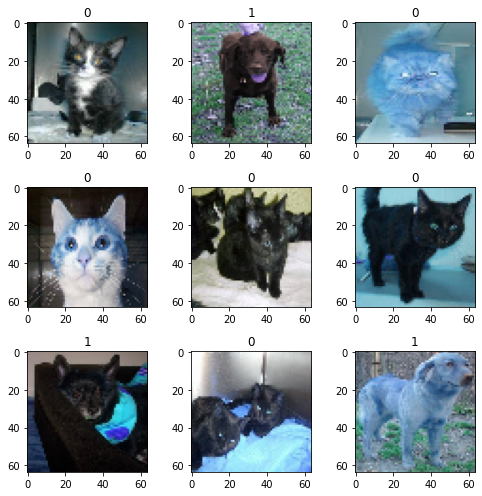

In [6]:
# 随机检查label与图片是否可以对应上
# - 从train中抽取9个image和9个label

image_no = np.random.randint(0,3602, size=9) # 随机挑选9个数字

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(7,7))

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(train_images[image_no[i*3+j]])
        axes[i][j].set_title(train_labels[image_no[i*3+j]])
plt.tight_layout()

## 开始训练

- 定义DataLoader
- 模型的搭建
- 定义损失函数和优化器
- 开始训练

In [7]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 创建dataloader

- 需要进行transfer

In [8]:
# 定义DataLoader
# ---------
# 转换为tensor
# ---------
X_train = torch.from_numpy(train_images.reshape(-1, 3, 64, 64)).float() # 输入 x 张量
X_test = torch.from_numpy(test_images.reshape(-1, 3, 64, 64)).float()
Y_train = torch.from_numpy(train_labels).long() # 输入 y 张量
Y_test = torch.from_numpy(test_labels).long()
print(X_train.shape, Y_train.shape)
# ---------------
# 创建dataloader
# ---------------
MINIBATCH_SIZE = 200

trainDataset = torch.utils.data.TensorDataset(X_train, Y_train) # 合并训练数据和目标数据
trainDataloader = torch.utils.data.DataLoader(
    dataset=trainDataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=1           # set multi-work num read data
)

testDataset = torch.utils.data.TensorDataset(X_test, Y_test) # 数据路径
testDataloader = torch.utils.data.DataLoader(
    dataset=testDataset,
    batch_size=MINIBATCH_SIZE, # 批量大小
    shuffle=True, # 乱序
    num_workers=1 # 多进程
)

torch.Size([22500, 3, 64, 64]) torch.Size([22500])


### 模型的定义

In [0]:
torch.cuda.empty_cache()

In [10]:
# 模型的定义
# -------
# 定义网络
# -------
class ModuleWrapperIgnores2ndArg(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self,x, dummy_arg=None):
        assert dummy_arg is not None
        x = self.module(x)
        return x


class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        # 参数的定义
        # 卷积层+池化层
        self.conv1 = nn.Sequential(
            # 第一层
            nn.Conv2d(kernel_size=2, in_channels=3, out_channels=64, stride=1, padding=1), 
            nn.BatchNorm2d(64), # 加上BN的结果
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            # 第二层
            nn.Conv2d(kernel_size=2, in_channels=64, out_channels=128, stride=1, padding=1),
            nn.BatchNorm2d(128), # 加上BN的结果
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            # 第三层
            nn.Conv2d(kernel_size=2, in_channels=128, out_channels=256, stride=1, padding=1),
            nn.BatchNorm2d(256), # 加上BN的结果
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        self.conv2 = nn.Sequential(
            # 第四层
            nn.Conv2d(kernel_size=2, in_channels=256, out_channels=256, stride=2, padding=1),
            nn.BatchNorm2d(256), # 加上BN的结果
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 第五层
            nn.Conv2d(kernel_size=3, in_channels=256, out_channels=256, stride=3, padding=1),
            nn.BatchNorm2d(256), # 加上BN的结果
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        # 全连接层
        self.line = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.Dropout(p=0.7),
            nn.Linear(in_features=512, out_features=2)
        )

        # 用来checkpoints
        # self.dummy_tensor = torch.ones(1, dtype=torch.float32, requires_grad=True)
        # self.module_wrapper = ModuleWrapperIgnores2ndArg(self.conv1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv(x)
        x = x.view(x.size(0), -1) #展开
        x = self.line(x)
        return x

# ------------
# 查看网络结构
# ------------
Cnn = cnn().to(device)
print(Cnn)

# ------------
# 测试输入数据
# ------------
Cnn(X_train[0:3].to(device))

cnn(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

tensor([[ 0.8395,  0.9863],
        [ 0.2413,  0.2006],
        [ 0.3028, -1.0946]], device='cuda:0', grad_fn=<AddmmBackward>)

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr  5 21:53:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    36W / 250W |    875MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### 定义优化器和损失函数&开始训练

In [12]:
loss_fn = nn.CrossEntropyLoss() # 定义损失函数
optimiser = optim.Adam(params=Cnn.parameters(), lr=0.001) # 定义优化器

print('开始训练.')
num_epochs = 42
total_step = len(trainDataloader) # 每一个epoch中的步骤
lossList = []
AccuryList = []
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=45*7, gamma=0.9) # 学习率每20轮变为原来的90%
for epoch in range(num_epochs):
    Cnn.train() # 训练模式
    totalLoss = 0 # 计算训练集的平均loss
    for i, (images, labels) in enumerate(trainDataloader):
        images = images.to(device)
        labels = labels.to(device)
        pre = Cnn(images) # 模型的预测结果
        loss = loss_fn(pre, labels) # 计算误差
        # 反向传播
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lr_scheduler.step()
        # 计算平均loss
        totalLoss = totalLoss + loss.item()
        # ---------
        # 打印结果
        # ---------
        if (i+2) % 30 == 0:
            t = datetime.now() #获取现在的时间
            print('Time {}, Epoch [{}/{}], Step [{}/{}], loss:{:.4f}'.format(t, epoch, num_epochs, i+1, total_step, totalLoss/(i+1)))
            # 看一下训练集准确率
            _, predicted = torch.max(pre.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            print('Training Accuracy: {}, Training Rate: {}'.format(100 * correct / total, optimiser.param_groups[0]['lr']))

    lossList.append(totalLoss/(i+1))
    # --------------------------
    # 每一个epoch对测试集进行测试
    # --------------------------
    Cnn.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testDataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = Cnn(images) # 模型的预测结果(概率)
            _, predicted = torch.max(outputs.data, 1) # 模型的预测结果(对应到是哪一个label)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
    AccuryList.append(correct / total)
    print('-'*10)

开始训练.
Time 2020-04-05 21:53:39.869247, Epoch [0/42], Step [29/113], loss:1.0304
Training Accuracy: 60.0, Training Rate: 0.001
Time 2020-04-05 21:53:49.847423, Epoch [0/42], Step [59/113], loss:0.8658
Training Accuracy: 65.5, Training Rate: 0.001
Time 2020-04-05 21:53:59.824708, Epoch [0/42], Step [89/113], loss:0.8034
Training Accuracy: 55.0, Training Rate: 0.001
Test Accuracy of the model on the 10000 test images: 57.12 %
----------
Time 2020-04-05 21:54:18.782958, Epoch [1/42], Step [29/113], loss:0.6638
Training Accuracy: 60.5, Training Rate: 0.001
Time 2020-04-05 21:54:28.772143, Epoch [1/42], Step [59/113], loss:0.6493
Training Accuracy: 67.0, Training Rate: 0.001
Time 2020-04-05 21:54:38.763693, Epoch [1/42], Step [89/113], loss:0.6437
Training Accuracy: 65.5, Training Rate: 0.001
Test Accuracy of the model on the 10000 test images: 63.44 %
----------
Time 2020-04-05 21:54:57.729983, Epoch [2/42], Step [29/113], loss:0.6119
Training Accuracy: 68.0, Training Rate: 0.001
Time 2020-

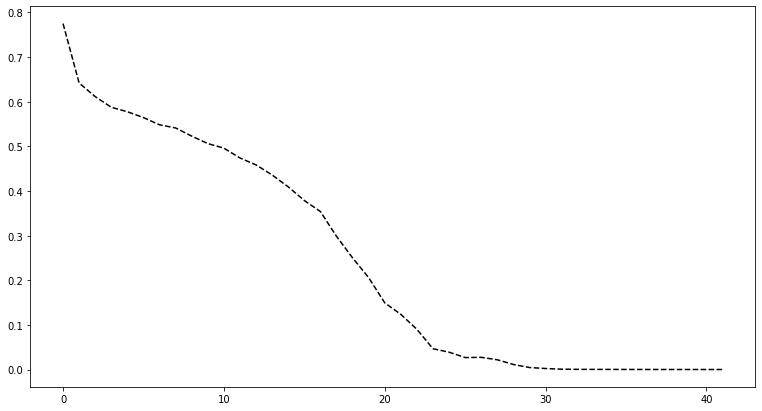

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(13,7))
axes.plot(lossList, 'k--')

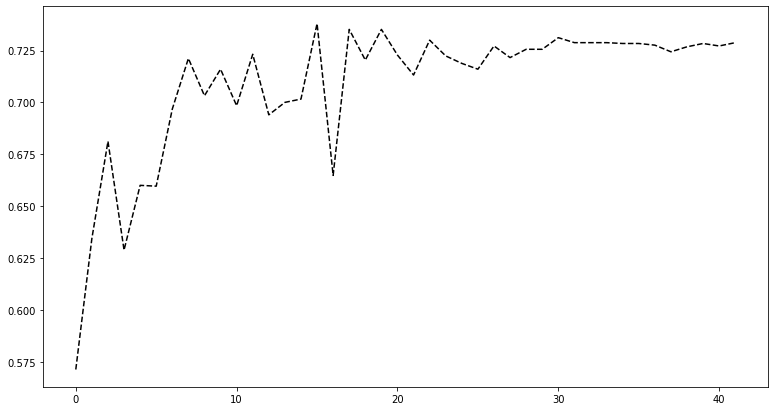

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(13,7))
axes.plot(AccuryList, 'k--')